# NLP - Assignment 5
## HW Group 7

For this assignment, you will be tasked with performing text classification using transformers models. You will compare two approaches:

1. Fine-tune a transformer model with text truncation. Most of the data will be longer than the context window of many BERT models. Fine-tune a model by simply truncating the text to max model length.

2. Fine-tune a transformer model by segmenting the text such that it fits within the context window of the model. Every chunk within the document would get the same label.

## Dataset Preview
The data source used for this assignment is: https://huggingface.co/datasets/ccdv/patent-classification

In [38]:
import sys
from datasets import load_dataset
import pandas as pd
import numpy as np
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
import nltk
import torch
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    confusion_matrix,
    accuracy_score,
    f1_score,
    classification_report
)
import matplotlib.pyplot as plt

In [3]:
# Load the dataset
dataset = load_dataset("ccdv/patent-classification")

# Check the available splits
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.25k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/194M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/39.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/39.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})


In [4]:
# Filter the top 4 most frequent labels

train_data = dataset['train']
train_df = pd.DataFrame(train_data)
label_counts = train_df['label'].value_counts()
top_4_labels = label_counts.head(4).index.tolist()

# Filter the dataset to only include top 4 labels
dataset = dataset.filter(lambda x: x["label"] in top_4_labels)

top_4_labels

Filter:   0%|          | 0/25000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5000 [00:00<?, ? examples/s]

[6, 7, 0, 1]

In [5]:
# Create remapping dictionaries
label2id = {label_name: new_id for new_id, label_name in enumerate(top_4_labels)}
id2label = {v: dataset["train"].features["label"].names[k] for k, v in label2id.items()}

print("id2label (for model):", id2label)

id2label (for model): {0: 'Physics', 1: 'Electricity', 2: 'Human Necessities', 3: 'Performing Operations; Transporting'}


In [6]:
# Filter the top 4 labels and remap to 0–3
def filter_and_remap(example):
    if example["label"] in label2id:
        example["label"] = label2id[example["label"]]  # remap to 0-3
        return True
    return False

# Apply filter + remap to all splits
dataset = dataset.map(lambda x: {"label": label2id[x["label"]]})

Map:   0%|          | 0/17700 [00:00<?, ? examples/s]

Map:   0%|          | 0/3549 [00:00<?, ? examples/s]

Map:   0%|          | 0/3545 [00:00<?, ? examples/s]

## Fine-tune a transformer model with text truncation

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenize with truncation enabled
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=512)

dataset_tokens = dataset.map(tokenize, batched=True, batch_size=100, num_proc=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map (num_proc=2):   0%|          | 0/17700 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/3549 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/3545 [00:00<?, ? examples/s]

In [ ]:
# Rename label column to 'labels' as expected by transformers
tokenized_dataset = dataset_tokens.rename_column("label", "labels")
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=4,
    id2label=id2label,
    label2id={v: k for k, v in id2label.items()}
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define trainer and training arguments
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./bert-patent-truncation",
    num_train_epochs=1,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-16-15fbc794d355>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the model
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ywpeng01 (ywpeng01-university-of-chicago) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.594700,0.562363


TrainOutput(global_step=1107, training_loss=0.6791544210404669, metrics={'train_runtime': 1831.4221, 'train_samples_per_second': 9.665, 'train_steps_per_second': 0.604, 'total_flos': 4657149307699200.0, 'train_loss': 0.6791544210404669, 'epoch': 1.0})

In [ ]:
# Evaluate model performance on the test set
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.5623633861541748, 'eval_runtime': 107.2305, 'eval_samples_per_second': 33.06, 'eval_steps_per_second': 2.07, 'epoch': 1.0}


In [ ]:
pred_output = trainer.predict(tokenized_dataset["test"])
pred_output

PredictionOutput(predictions=array([[-0.92712116, -1.9983867 ,  0.79597557,  2.1967158 ],
       [ 1.2615396 ,  0.6378177 , -0.30226728, -1.3828747 ],
       [-1.5686469 , -2.0249703 ,  2.7461119 ,  1.0409653 ],
       ...,
       [-0.67494565, -1.797619  ,  0.37767047,  2.4263947 ],
       [-0.48465836,  3.0016744 , -1.8158183 , -0.78447294],
       [-1.0605118 , -2.0823562 ,  0.9509796 ,  2.8657625 ]],
      dtype=float32), label_ids=array([3, 0, 3, ..., 3, 1, 3]), metrics={'test_loss': 0.5623633861541748, 'test_runtime': 98.9889, 'test_samples_per_second': 35.812, 'test_steps_per_second': 2.243})

In [ ]:
pred_output.metrics

{'test_loss': 0.5623633861541748,
 'test_runtime': 98.9889,
 'test_samples_per_second': 35.812,
 'test_steps_per_second': 2.243}

In [ ]:
y_pred = pred_output.predictions.argmax(axis=1)
y_pred

array([3, 0, 2, ..., 3, 1, 3])

In [ ]:
y_test = np.array(tokenized_dataset["test"]["labels"])

In [ ]:
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.xticks(rotation=45, ha="right")
    plt.show()

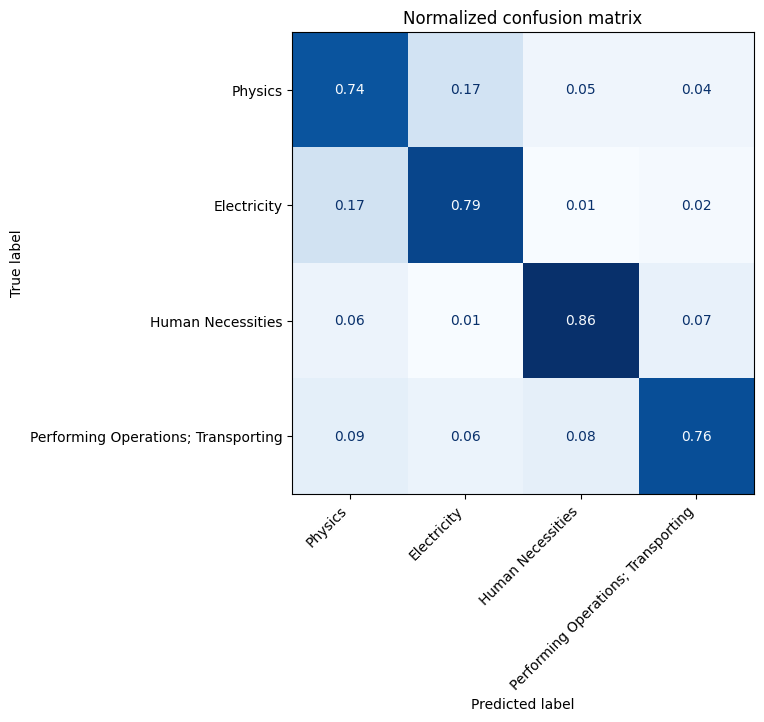

In [ ]:
plot_confusion_matrix(y_pred, y_test, list(id2label.values()))

### Model Evaluation for Approach 1:
The model demonstrates reasonably good performance, especially in classifying “Human Necessities” with 86% accuracy. However, it struggles more with “Electricity” and “Physics,” where around 17% and 6% of examples are misclassified as other categories. This indicates that some semantic overlap between classes may be affecting classification accuracy.

## Fine-tune a transformer model by segmenting the text such that it fits within the context window of the model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
max_length = tokenizer.model_max_length  # 512 in this case

# Text chunking function
def segment_text(text):
    sentences = nltk.sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for sent in sentences:
        sent_length = len(tokenizer.tokenize(sent))

        if sent_length > max_length:
            words = sent.split()
            for word in words:
                word_length = len(tokenizer.tokenize(word))
                if current_length + word_length > max_length:
                    if current_chunk:
                        chunks.append(" ".join(current_chunk))
                        current_chunk = []
                        current_length = 0
                current_chunk.append(word)
                current_length += word_length
        else:
            if current_length + sent_length > max_length:
                if current_chunk:
                    chunks.append(" ".join(current_chunk))
                    current_chunk = []
                    current_length = 0
            current_chunk.append(sent)
            current_length += sent_length

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

In [8]:
# Dataset processing function
def process_examples(examples):
    segmented_texts = []
    labels = []

    for text, label in zip(examples["text"], examples["label"]):
        chunks = segment_text(text)
        segmented_texts.extend(chunks)
        labels.extend([label] * len(chunks))

    return {"text": segmented_texts, "label": labels}

In [ ]:
# Apply text segmenting
segmented_dataset = dataset.map(
    process_examples,
    batched=True,
    remove_columns=dataset["train"].column_names,
    batch_size=100
)

In [11]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=max_length)

In [ ]:
# Apply tokenizer
tokenized_dataset = segmented_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"],
    batch_size=100
)

In [13]:
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

In [ ]:
model_2 = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(top_4_labels),
    id2label=id2label
)

In [26]:
# Define trainer and training arguments
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_args = TrainingArguments(
    output_dir="./bert-patent-truncation",
    num_train_epochs=1,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

<ipython-input-26-dc1460173745>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [27]:
# Train the model for second approach
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.428900,0.654569


TrainOutput(global_step=9429, training_loss=0.5150155514393344, metrics={'train_runtime': 4232.9703, 'train_samples_per_second': 35.638, 'train_steps_per_second': 2.228, 'total_flos': 3.969206789060198e+16, 'train_loss': 0.5150155514393344, 'epoch': 1.0})

In [28]:
# Evaluate model performance on the test set
metrics = trainer.evaluate()
print(metrics)

{'eval_loss': 0.6545693278312683, 'eval_runtime': 234.292, 'eval_samples_per_second': 129.27, 'eval_steps_per_second': 8.08, 'epoch': 1.0}


In [30]:
# Redefine plot confusion matrix function
def plot_confusion_matrix(y_true, y_pred, labels, normalize="true", figsize=(8,6)):
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)

    fig, ax = plt.subplots(figsize=figsize)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=labels
    )

    disp.plot(
        cmap="Blues",
        values_format=".2f" if normalize else "d",
        ax=ax,
        colorbar=False,
        im_kw={"vmin": 0}
    )

    plt.title(f"{'Normalized' if normalize else ''} Confusion Matrix")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [31]:
original_test = dataset["test"]

In [36]:
def predict_document(text):
    chunks = segment_text(text)
    inputs = tokenizer(chunks, truncation=True, padding=True, return_tensors="pt", max_length=max_length)
    with torch.no_grad():
        outputs = model(**inputs.to(model.device))
    probs = torch.softmax(outputs.logits, dim=-1)
    return probs.mean(dim=0).argmax().item()

In [39]:
y_true = []
y_pred = []

for text, label in zip(original_test["text"], original_test["label"]):
    y_true.append(label)
    y_pred.append(predict_document(text))  # Use document level prediction

# Display classification metrics for all categories
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(id2label.values())))

Classification Report:
                                     precision    recall  f1-score   support

                            Physics       0.80      0.78      0.79      1107
                        Electricity       0.80      0.83      0.81      1035
                  Human Necessities       0.87      0.87      0.87       754
Performing Operations; Transporting       0.81      0.79      0.80       649

                           accuracy                           0.82      3545
                          macro avg       0.82      0.82      0.82      3545
                       weighted avg       0.82      0.82      0.82      3545




Confusion Matrix:


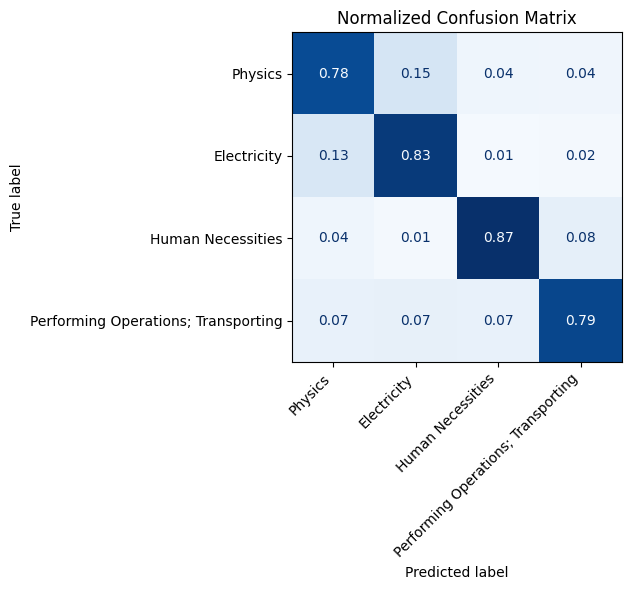

In [40]:
print("\nConfusion Matrix:")
plot_confusion_matrix(y_true, y_pred, list(id2label.values()))

In [41]:
# Display chunk statistics
print(f"\nChunk Statistics: Avg chunks per doc = {len(tokenized_dataset['test']) / len(original_test):.1f}")


Chunk Statistics: Avg chunks per doc = 8.5


### Model Evaluation for Approach 2
The second approach slightly improves overall classification accuracy, particularly for “Physics” (78%) and “Electricity” (83%). Misclassification rates across all categories are lower compared to Approach 1, suggesting that the model benefits from improved input formatting by segmenting instead of text truncation in this approach.

### Segmentation Approach
For the segmentation-based fine-tuning approach, *we* implemented a dynamic sentence-aware chunking strategy to split long patent texts into manageable segments that fit within the transformer model's maximum context window (e.g., 512 tokens for BERT). Below is the detailed procedure of the approach:
1. Segmentation
- Sentence-first splitting: We used nltk.sent_tokenize() to split documents into sentences, which helps preserve linguistic boundaries. For sentences longer than max_length, fell back to word-level splitting to avoid truncation.
- Dynamic chunking: We ieratively merged sentences into chunks until adding the next sentence would exceed max_length.
2. Label Assignment
- All chunks from the same document shared the original label.
To sum it up, the segmentation apporach ensures no hard truncation and semantic coherence.

### What kind of post-processing would you need to use to assign a new document to a class?
For the segmentation approach where a document is split into multiple chunks
while each receiving its own prediction, the key post-processing step is **aggregating chunk-level predictions** into a final document-level label.<br>
Some common ways of aggregation include majority voting, which is to assign the label that appears most frequently across chunks, and probability mean, which is to	average the softmax probabilities of all chunks and then argmax the result.
To balance performance and simplicity, we choose and implement the **probability mean** as the aggregation approach in the above code to test the model performance. For the assignment of a new document in the future, we also need to use the aggregation approach to firstly aggregate the chunk-level predictions, and make the final document level label assignment.